<a href="https://colab.research.google.com/github/srush/drop7/blob/main/Drop7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!sudo apt-get install libcairo2-dev
!pip install git+https://github.com/chalk-diagrams/chalk/ pycairo Pillow

In [22]:
from chalk import *
from colour import Color
import jax.numpy as np
import jax
from jax.lax import scan
import random
from IPython.display import display, clear_output
import numpy as onp

# board
black, red, grey, white = (Color(c) for c in ["black", "red", "grey", "white"])
colors = list([Color(c) for c in ["red", "blue", "green", "orange", "purple", "darkblue", "darkgreen"]])

init = """
_____3_
2_3____
4_24477
4155762
4466256
XXXXXXX
XXXXXXX
""".strip().split()
board = onp.zeros((7, 7, 7), int)
block = onp.zeros((7, 7), int)
for r in range(7):
    for c in range(7):
        sym = init[r][c]
        if sym != "_":
            if sym == "X":
                board[6 - r, c, random.randint(0, 6)] = 1
                block[6-r, c] = 1
            else:
                board[6 - r, c, int(sym) - 1] = 1

## Drawing the board.

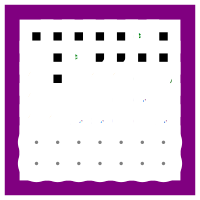

In [73]:
def draw(board, block, burst=np.zeros((7, 7))):
    board, burst = onp.array(board), onp.array(burst)
    def draw_token(pos):
        return rectangle(1, 1).fill_color(black).line_color(white) \
            + concat([circle(0.4).line_color(grey).line_width(0).fill_color(colors[n]) +
                      text(str(n.item()+1), 0.5).line_color(white).fill_color(white)
                      for n in pos])
    def draw_burst():
        return regular_polygon(7, 0.1).line_color(grey).fill_color(red)
    def draw_block():
        return circle(0.4).fill_color(grey).line_color(white).line_width(0.4)
    out = vcat([hcat([draw_token(board[row, col].nonzero()[0]) +
                      (draw_burst() if burst[row, col] else empty()) +
                       (draw_block() if block[row, col] else empty())
        for col in range(7)]) for row in reversed(range(7))])
    return (rectangle(9, 9).fill_color(colors[4]).line_width(0)) +  out.center_xy()
display(draw(board, block))

# Game code

In [41]:
@jax.jit
def fall(b):
    up = np.convolve(b.sum(-1)*2-1 , np.array([0, 1, -1]), "same")[:, None] >= 2
    return b * (1-up) + np.roll(b * up, -1, 0), up

@jax.jit
def reduce(b, c):
    def count(arr, rev=False):
        return scan(lambda c, x: 2*(x * c + x,), 0, arr, reverse=rev)[1]
    bs = (b * np.arange(1, 8)).sum(-1)
    exp = (c == 0) & (bs == (count(bs > 0) + count(bs > 0, rev=True) - 1))
    return b * (1-exp)[..., None], exp

@jax.jit
def unblock(exp):
    return np.convolve(exp , np.array([1, 0, 1]), "same")

reduce_row, reduce_col = jax.vmap(reduce), jax.vmap(reduce, 1, 1)
unblock_row, unblock_col = jax.vmap(unblock), jax.vmap(unblock, 1, 1)
fall = jax.vmap(fall, 1, 1)

# Run the game

In [50]:
def run(board, block):
    board, block = np.array(board), np.array(block)
    boards = [(board, block)]
    while True:
        board, keep = fall(board)
        boards.append((board, block))
        if not keep.any():
            board1, exp1 = reduce_col(board, block)
            board2, exp2 = reduce_row(board, block)
            exp = exp1 + exp2
            board = board1 & board2
            if exp.sum() != 0:
                for i in range(2):
                    boards.append((board, block, exp))
                    boards.append((board, block, ))
            block = np.maximum(0, block - (unblock_col(exp) + unblock_row(exp)))
            boards.append((board, block,))
            if exp.sum() == 0:
                break
    return boards

output = run(board, block)

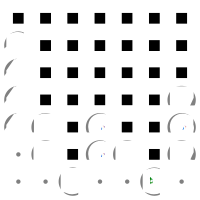

In [39]:
for b in output:
    clear_output(wait=True)
    display(draw(*b))

## Code to save game as a gif

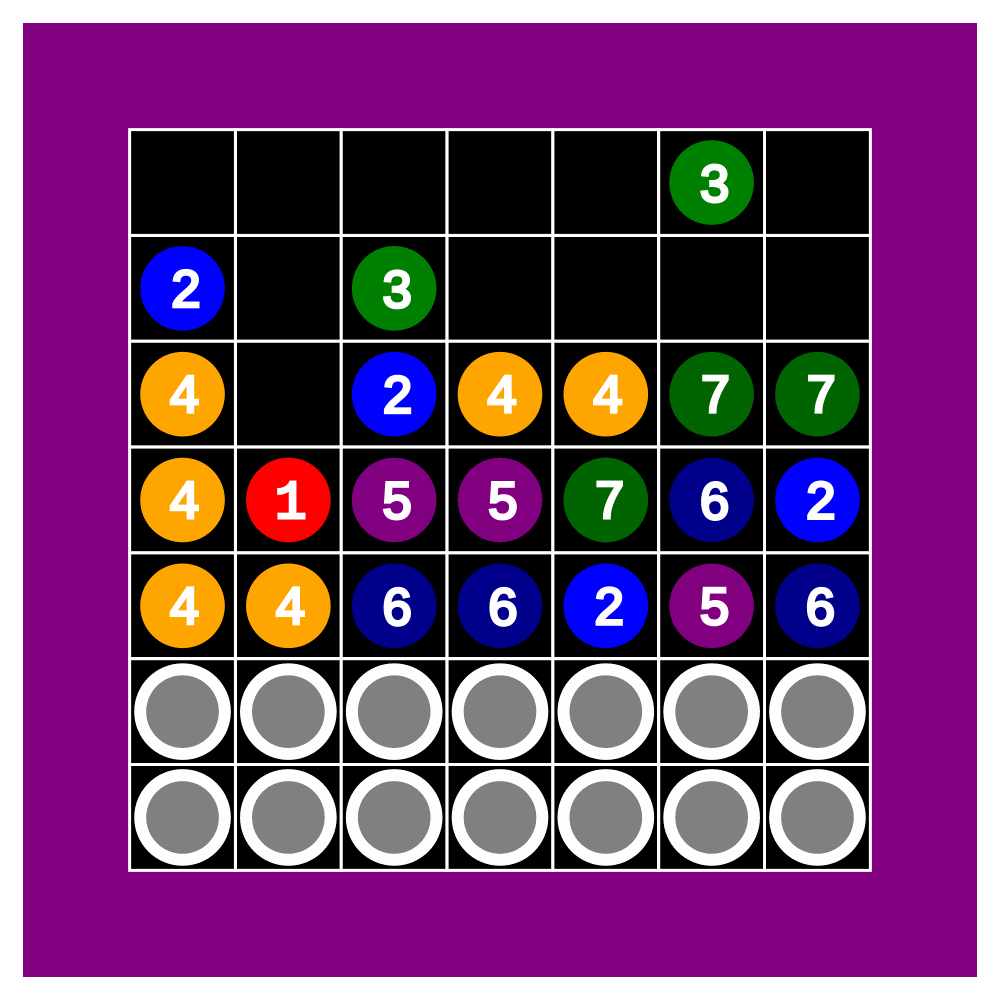

In [74]:

import PIL
import os
import IPython

# Animate PNGs to GIF
def pngs_to_gif(names, output_gif):
    images = [PIL.Image.open(png) for png in names if png.endswith('.png')]
    images[0].save(output_gif, save_all=True, append_images=images[1:], duration=125,loop=0)

def animate_game(diagrams):
    names = []
    png_names = []
    for i, d in enumerate(diagrams):
        png_names.append(f"image{i}.png")
        d.render(png_names[-1], 1000)
    pngs_to_gif(png_names, "show.gif")
    return IPython.display.Image("show.gif")
animate_game([draw(*d) for d in output])